<a href="https://colab.research.google.com/github/FudgeSato/Quant-Backtesting-Monte-Carlo/blob/pytorch-model/6_Form_Quant_Backtest_Mistral_Pytorch_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta
import torch
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=479693f4e909d87cbfe7be9658abe502b057a79b59187b79fb3be9bc914c0976
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Enter the stock ticker symbol (e.g., AAPL): AAPL
Choose a trading strategy:
1. Moving Average Crossover
2. RSI Stochastic
3. Fibonacci Retracement
4. Bollinger Bands
5. MACD Crossover
6. ATR-Based Volatility
Enter the number corresponding to your choice: 2


[*********************100%***********************]  1 of 1 completed


Highest Win: 5432.33%
Worst Loss: -81.69%
Average Performance: 276.22%


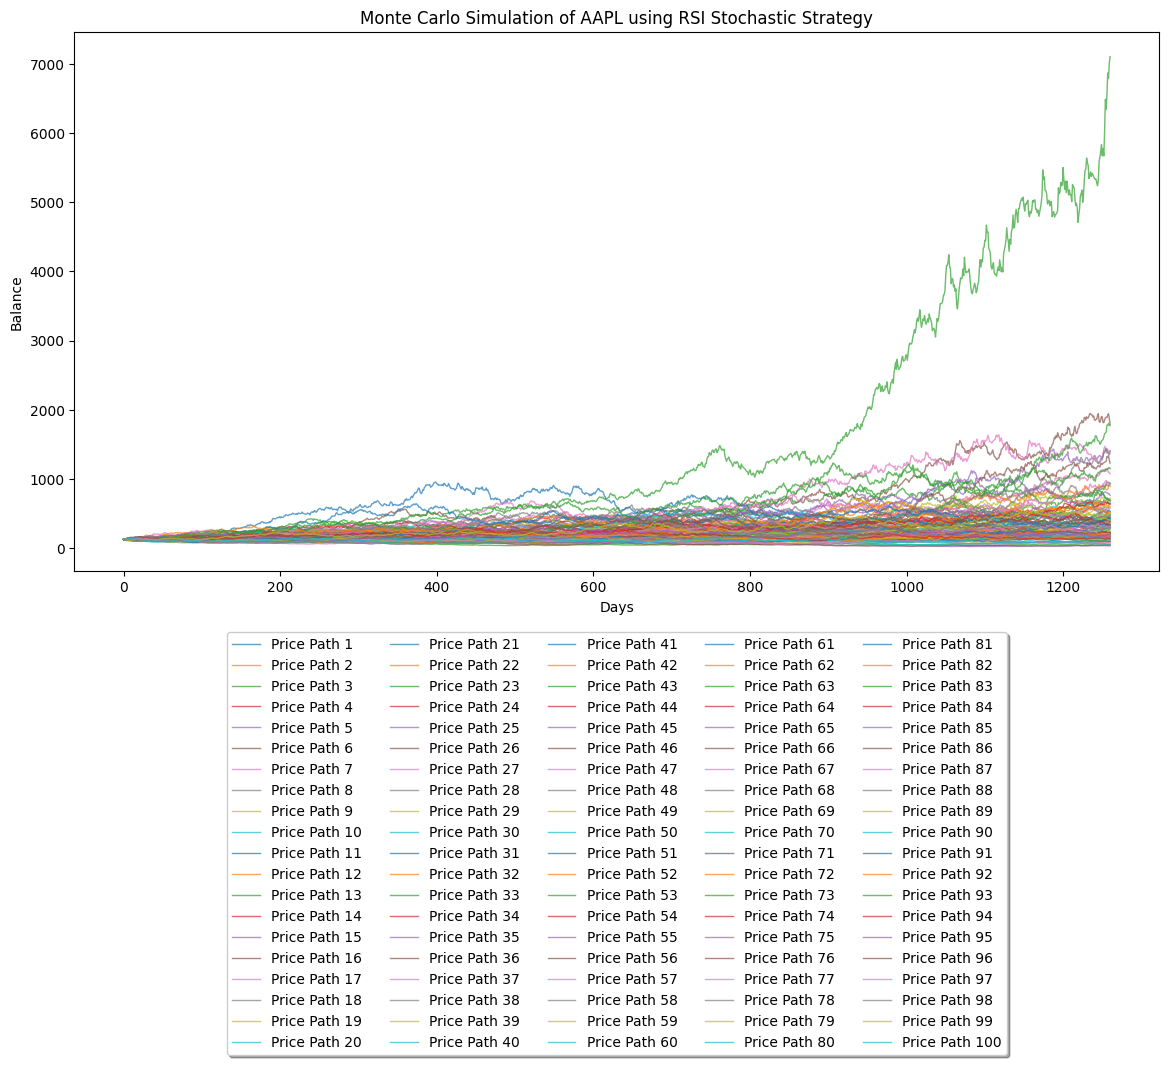

In [21]:
import torch
import pandas as pd
import yfinance as yf
import ta
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_user_input():
    ticker = input("Enter the stock ticker symbol (e.g., AAPL): ").strip().upper()
    print("Choose a trading strategy:")
    print("1. Moving Average Crossover")
    print("2. RSI Stochastic")
    print("3. Fibonacci Retracement")
    print("4. Bollinger Bands")
    print("5. MACD Crossover")
    print("6. ATR-Based Volatility")
    strategy_choice = int(input("Enter the number corresponding to your choice: ").strip())
    return ticker, strategy_choice

def generate_price_path(mean_return, std_return, initial_price, num_days, historical_data):
    # Convert mean_return and std_return to floats before passing to torch.normal
    # Use .item() to get the scalar value from the Series
    returns = torch.normal(float(mean_return.item()), float(std_return.item()), (num_days,), device=device)
    # Convert initial_price to a PyTorch tensor before multiplication
    # Use .item() to get the scalar value from the Series
    initial_price_tensor = torch.tensor(initial_price.item(), device=device, dtype=returns.dtype)
    price_path = initial_price_tensor * torch.cumprod(1 + returns, dim=0)

    # Reshape the initial_price tensor to have the same number of dimensions as price_path
    initial_price_tensor = initial_price_tensor.reshape(1)

    # Concatenate along the correct dimension (dim=0)
    price_path = torch.cat((initial_price_tensor, price_path), dim=0)

    price_path_df = pd.DataFrame(price_path.cpu().numpy(), columns=['Close'])

    # Sample High and Low from historical data, ensuring alignment with the simulated 'Close' dates
    num_simulated_days = len(price_path_df)
    sampled_high_low = historical_data[['High', 'Low']].sample(n=num_simulated_days, replace=True)
    sampled_high_low.index = price_path_df.index  # Align indices

    price_path_df['High'] = sampled_high_low['High']
    price_path_df['Low'] = sampled_high_low['Low']

    return price_path_df

def generate_simulations(historical_data, num_simulations, num_days):
    returns = historical_data['Close'].pct_change().dropna()
    mean_return = returns.mean()
    std_return = returns.std()
    initial_price = historical_data['Close'].iloc[-1]

    # Fix: Get the dtype directly from the 'Close' Series or define it when creating the tensor
    initial_price_tensor = torch.tensor(initial_price.item(), device=device, dtype=torch.float64)  # or dtype=historical_data['Close'].dtype

    simulations = []
    for _ in range(num_simulations):
        # Pass historical_data to generate_price_path
        price_path_df = generate_price_path(mean_return, std_return, initial_price, num_days, historical_data)
        simulations.append(price_path_df)

    return simulations

def moving_average_crossover_strategy(price_path):
    short_window = 40
    long_window = 100
    signals = pd.DataFrame(index=price_path.index)
    signals['Close'] = price_path['Close']
    signals['short_mavg'] = signals['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = signals['Close'].rolling(window=long_window, min_periods=1).mean()
    # Convert the condition to a PyTorch Tensor
    condition = torch.tensor(signals['short_mavg'].values > signals['long_mavg'].values, device=device, dtype=torch.bool)
    # Use torch.where with the Tensor condition and the desired values
    signals['signal'] = torch.where(condition, 1.0, 0.0).cpu().numpy()  # Convert back to NumPy array
    signals['positions'] = signals['signal'].diff()
    return signals

def rsi_stochastic_strategy(price_path):
    rsi_period = 14
    stoch_period = 14
    k_period = 3
    d_period = 3

    price_path = pd.DataFrame(price_path, columns=['Close', 'High', 'Low'])
    price_path['RSI'] = ta.momentum.rsi(price_path['Close'], window=rsi_period)
    price_path['Stoch_K'] = ta.momentum.stoch(price_path['High'], price_path['Low'], price_path['Close'], window=stoch_period, smooth_window=k_period)
    price_path['Stoch_D'] = price_path['Stoch_K'].rolling(window=d_period).mean()

    price_path['signal'] = 0.0
    price_path.loc[(price_path['RSI'] < 30) & (price_path['Stoch_K'] < price_path['Stoch_D']), 'signal'] = 1.0
    price_path.loc[(price_path['RSI'] > 70) & (price_path['Stoch_K'] > price_path['Stoch_D']), 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def fibonacci_retracement_strategy(price_path):
    def calculate_fibonacci_levels(price_min, price_max):
        diff = price_max - price_min
        return {
            '61.8%': price_max - 0.618 * diff,
            '50%': price_max - 0.5 * diff,
            '38.2%': price_max - 0.382 * diff
        }

    window = 20
    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['signal'] = 0.0

    for i in range(window, len(price_path)):
        price_window = price_path['Close'][i-window:i]
        price_min = price_window.min()
        price_max = price_window.max()
        fib_levels = calculate_fibonacci_levels(price_min, price_max)

        current_price = price_path['Close'].iloc[i]
        if current_price <= fib_levels['38.2%']:
            price_path.at[price_path.index[i], 'signal'] = 1.0
        elif current_price >= fib_levels['61.8%']:
            price_path.at[price_path.index[i], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def bollinger_bands_strategy(price_path):
    window = 20
    num_std_dev = 2

    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['SMA'] = price_path['Close'].rolling(window=window).mean()
    price_path['STD'] = price_path['Close'].rolling(window=window).std()
    price_path['Upper_Band'] = price_path['SMA'] + (price_path['STD'] * num_std_dev)
    price_path['Lower_Band'] = price_path['SMA'] - (price_path['STD'] * num_std_dev)

    price_path['signal'] = 0.0
    price_path.loc[price_path['Close'] < price_path['Lower_Band'], 'signal'] = 1.0
    price_path.loc[price_path['Close'] > price_path['Upper_Band'], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def macd_crossover_strategy(price_path):
    short_ema_window = 12
    long_ema_window = 26
    signal_window = 9

    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['EMA_Short'] = price_path['Close'].ewm(span=short_ema_window, adjust=False).mean()
    price_path['EMA_Long'] = price_path['Close'].ewm(span=long_ema_window, adjust=False).mean()
    price_path['MACD'] = price_path['EMA_Short'] - price_path['EMA_Long']
    price_path['Signal_Line'] = price_path['MACD'].ewm(span=signal_window, adjust=False).mean()

    price_path['signal'] = 0.0
    price_path.loc[price_path['MACD'] > price_path['Signal_Line'], 'signal'] = 1.0
    price_path.loc[price_path['MACD'] < price_path['Signal_Line'], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def atr_volatility_strategy(price_path):
    atr_period = 14
    multiplier = 2

    price_path = pd.DataFrame(price_path, columns=['Close'], index=range(len(price_path)))
    price_path['High'] = price_path['Close']
    price_path['Low'] = price_path['Close']
    price_path['ATR'] = ta.volatility.average_true_range(price_path['High'], price_path['Low'], price_path['Close'], window=atr_period)

    price_path['Upper_Band'] = price_path['Close'] + (price_path['ATR'] * multiplier)
    price_path['Lower_Band'] = price_path['Close'] - (price_path['ATR'] * multiplier)

    price_path['signal'] = 0.0
    price_path.loc[price_path['Close'] < price_path['Lower_Band'], 'signal'] = 1.0
    price_path.loc[price_path['Close'] > price_path['Upper_Band'], 'signal'] = -1.0

    price_path['positions'] = price_path['signal'].diff()
    return price_path

def main():
    ticker, strategy_choice = get_user_input()

    spy_data = yf.download(ticker, start='2020-01-01', end='2023-01-01')

    num_simulations = 1000
    num_days = 252 * 5

    simulations = generate_simulations(spy_data, num_simulations, num_days)

    strategy_functions = {
        1: moving_average_crossover_strategy,
        2: rsi_stochastic_strategy,
        3: fibonacci_retracement_strategy,
        4: bollinger_bands_strategy,
        5: macd_crossover_strategy,
        6: atr_volatility_strategy
    }

    strategy_names = {
        1: "Moving Average Crossover",
        2: "RSI Stochastic",
        3: "Fibonacci Retracement",
        4: "Bollinger Bands",
        5: "MACD Crossover",
        6: "ATR-Based Volatility"
    }

    strategy_function = strategy_functions.get(strategy_choice)
    strategy_name = strategy_names.get(strategy_choice)

    if strategy_function is None:
        print("Invalid strategy choice.")
        return

    results = [strategy_function(sim) for sim in simulations]

    performance = []
    for result in results:
        initial_price = result['Close'].iloc[0]
        final_price = result['Close'].iloc[-1]
        performance.append((final_price - initial_price) / initial_price * 100)

    highest_win = torch.tensor(performance, device=device).max().item()
    worst_loss = torch.tensor(performance, device=device).min().item()
    average_performance = torch.tensor(performance, device=device).mean().item()

    print(f"Highest Win: {highest_win:.2f}%")
    print(f"Worst Loss: {worst_loss:.2f}%")
    print(f"Average Performance: {average_performance:.2f}%")

    plt.figure(figsize=(14, 7))
    for i in range(100):
        plt.plot(results[i].index, results[i]['Close'], label=f'Price Path {i+1}', alpha=0.7, linewidth=1)

    plt.title(f'Monte Carlo Simulation of {ticker} using {strategy_name} Strategy')
    plt.xlabel('Days')
    plt.ylabel('Balance')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    plt.show()

if __name__ == "__main__":
    main()
